## lab 3
### Supervised learning

Для начала импортируем все библиотеки(по ходу исследования я вспомню, что нужны ешё и метрики, поэтому заранее извините за импорты не в начале программы)

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

Затем загрузим наш датасет и посмотрим на него

In [3]:
data = pd.read_csv("students_data.csv")

In [4]:
print(data.head())

       ID Subject school sex  age address famsize Pstatus Medu Fedu  ...  \
0  100097     Por     GP   F   16       U     GT3       A    3    4  ...   
1  101021     Por     GP   F   17       U     GT3       T    3    2  ...   
2  102965     Por     GP   M   16       U     LE3       T    1    2  ...   
3  102989     Por     MS   M   17       U     GT3       T    2    3  ...   
4  103131     Por     GP   F   16       U     GT3       T    1    1  ...   

  freetime goout Dalc Walc  health  absences  cheating  G1  G2  G3  
0        2     1  1.0  4.0       5        12       NaN  15  13  14  
1        3     4  1.0  3.0       3         2       NaN  17  18  17  
2        4     5  3.0  5.0       5         0       yes   9   8  10  
3        4     3  1.0  1.0       3         4        no  14  15  16  
4        3     2  1.0  4.0       5         2       yes  12  13  13  

[5 rows x 36 columns]


In [5]:
data['Medu'] = data['Medu'].replace('o', '0')
data['Fedu'] = data['Fedu'].replace('o', '0')
data['sex'] = data['sex'].replace('m', 'M')
data['guardian'] = data['guardian'].replace('futher', 'father')
data['Fjob'] = data['Fjob'].replace('at-home', 'at_home')
data['Mjob'] = data['Mjob'].replace('at-home', 'at_home')
data['Pstatus'] = data['Pstatus'].replace('t', 'T')
data['famrel'] = data['famrel'].replace('3.93617', '4')  
data['Dalc'] = data['Dalc'].replace('1.497099', '1')
data['Walc'] = data['Walc'].replace('2.291103', '2')

#Затем распределим признаки по виду данных
for column in data:
    if type(data[column][0]) == str:
        print(column + ' ' + 'Категориальные данные')
    else:
        if data[column][0] <= 5 and data[column][0] >= 0:
            print(column + ' ' + 'Упорядоченные категориальные данные')
        else:
            print(column + ' ' + 'Числовые данные')
data.info()
data[:10]
data['Pstatus'].value_counts()

ID Числовые данные
Subject Категориальные данные
school Категориальные данные
sex Категориальные данные
age Числовые данные
address Категориальные данные
famsize Категориальные данные
Pstatus Категориальные данные
Medu Категориальные данные
Fedu Категориальные данные
Mjob Категориальные данные
Fjob Категориальные данные
reason Категориальные данные
guardian Категориальные данные
traveltime Упорядоченные категориальные данные
studytime Упорядоченные категориальные данные
failures Упорядоченные категориальные данные
schoolsup Категориальные данные
famsup Категориальные данные
paid Категориальные данные
activities Категориальные данные
nursery Категориальные данные
higher Категориальные данные
internet Категориальные данные
romantic Категориальные данные
famrel Упорядоченные категориальные данные
freetime Упорядоченные категориальные данные
goout Упорядоченные категориальные данные
Dalc Упорядоченные категориальные данные
Walc Упорядоченные категориальные данные
health Упорядоченные катег

T    923
A    121
Name: Pstatus, dtype: int64

Здесь происходит приведение категориальных признаков к числовым

In [6]:
data1 = data.drop('ID', axis=1)

In [7]:
data1['sex'].replace(['M','F'], [1, 0], inplace=True)
data1['school'].replace(['GP', 'MS'], [1, 0], inplace=True)
data1['Subject'].replace(['Por','Math'], [1, 0], inplace=True)
data1['Pstatus'].replace(['T', 'A'], [1, 0], inplace=True)
data1.replace(['yes', 'no'], [1, 0], inplace=True)
data1['guardian'].replace(['father', 'mother'], [1, 0], inplace=True)
data1['famsize'].replace(['GT3', 'LE3'], [1, 0], inplace=True)
data1['address'].replace(['U', 'R'], [1, 0], inplace=True)
#или признаки, числовое упорядочивание которых может быть оправдано, например 
data1['Medu'] = data['Medu'].astype(int)
data1['Fedu'] = data['Fedu'].astype(int)
data1.replace(['teacher', 'health', 'services', 'at_home', 'other'], [1, 2, 3, 4, 0], inplace=True)
data1.replace(['home', 'reputation', 'course'], [1, 2, 3], inplace=True)

Далее я выбираю признаки, по которым буду смотроить модель. 
Для начала возьмем все, что нам доступны

In [8]:
features_name = ['Subject', 'school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob',  'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1']
features_name_G1 = ['Subject', 'school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob',  'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Здесь заменяю пропуски медианами и удаляю 10 записей с пустыми romantic, потому что восстановить их по медиане не представляется возможным

In [9]:
data1 = data1.fillna(data.median())
data1 = data1.dropna()

In [10]:
X = data1[features_name]
y = data1['G3']
X_modified = data1[features_name_G1]

In [11]:
print(X.head())

    Subject  school  sex  age  address  famsize  Pstatus  Medu  Fedu  Mjob  \
2         1       1    1   16        1        0        1     1     2     2   
3         1       0    1   17        1        1        1     2     3     0   
8         0       1    0   15        1        0        1     3     2     3   
11        1       1    1   18        1        0        1     3     4     3   
13        1       1    1   15        1        1        1     4     3     1   

    ...  internet  romantic  famrel  freetime  goout  Dalc  Walc  health  \
2   ...         1       0.0     4.0         4      5   3.0   5.0       5   
3   ...         1       0.0     4.0         4      3   1.0   1.0       3   
8   ...         1       0.0     4.0         4      4   1.0   1.0       5   
11  ...         1       1.0     4.0         3      3   1.0   3.0       5   
13  ...         1       0.0     4.0         3      3   2.0   3.0       5   

    absences  G1  
2          0   9  
3          4  14  
8         10   7 

In [12]:
print(y.head())

2     10
3     16
8      6
11    17
13    11
Name: G3, dtype: int64


## задача регрессии

Кросс-валидацию доверил библиотечной функции, потому что соотношение 80/20 нам вполне подходит

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 43)
train_XG1, val_XG1, train_yG1, val_yG1 = train_test_split(X_modified, y, random_state = 43)

In [15]:
svc = DecisionTreeRegressor(max_leaf_nodes=4, random_state=43)
svc_tree = DecisionTreeRegressor(max_leaf_nodes=5, random_state=43)
rfc = AdaBoostRegressor(base_estimator=svc, learning_rate=0.00001, random_state=43)
rfc.fit(train_X, train_y)
predict_ADA = rfc.predict(val_X)

In [16]:
svcG1 = DecisionTreeRegressor(max_leaf_nodes=4, random_state=43)
svcG1_tree = DecisionTreeRegressor(max_leaf_nodes=5, random_state=43)
rfcG1 = AdaBoostRegressor(base_estimator=svc, learning_rate=0.00001, random_state=43)
rfcG1.fit(train_XG1, train_yG1)
predict_ADAG1 = rfcG1.predict(val_XG1)

In [17]:
from sklearn.metrics import explained_variance_score
print(explained_variance_score(val_y, predict_ADA))
print(explained_variance_score(val_y, predict_ADAG1))

0.7258872191846519
0.2668605240270363


In [18]:
svc.fit(train_X, train_y)
svc_tree.fit(train_X, train_y)
predict_tree = svc_tree.predict(val_X)
svcG1.fit(train_XG1, train_yG1)
predict_treeG1 = svcG1.predict(val_XG1)
print(explained_variance_score(val_y, predict_tree))
print(explained_variance_score(val_y, predict_treeG1))

0.702221643702204
0.2404098316733464


Для первой модели выбрана Adaboost потому что она мне нравится, лернинг рейт выбирался из принципа ручного подбора, потому что включать цикл ради одного параметра очень нерационально, к тому же, очевидно, что глобальный минимум ошибки здесь ведет себя достаточно предсказуемо

Сравнивалась эта модель с обычным деревом решений, как видно, при подборе параметров "на глаз" адабуст имеет небольшое преимущество

Если не включать признак G1 для тренировки модели, то ее точность неприлично падает, но я считаю это закономерным.

По статистике, вероятность того, что ученик будет иметь сильно разную успеваемость в рамках дного учебного года, крайне мала, поэтому модель ставит большой вес при признаке G1

In [19]:
from sklearn.linear_model import LogisticRegression
svc_Log = LogisticRegression(random_state=43, solver='newton-cg', max_iter=100000, multi_class='multinomial').fit(train_X, train_y)
predict_Log = svc_Log.predict(val_X)

In [20]:
print(explained_variance_score(val_y, predict_Log))

0.3477561112147789


Как видно из метрики, логистическая регрессия без танцев с бубном показывает очень плохой результат

## задача бинарной классификации

Прежде всего, необходимо создать новый признак, основанный на признаке G3

In [21]:
data1.loc[data1['G3'] >= 8, 'G_3'] = int(1)
data1.loc[data1['G3'] < 8, 'G_3'] = int(0)

In [22]:
print(data1['G_3'].head())

2     1.0
3     1.0
8     0.0
11    1.0
13    1.0
Name: G_3, dtype: float64


Способ достаточно колхозный, но очень эффективный по времени:)

In [23]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [24]:
y_G_3 = data1['G_3']
X_G_3 = data1[features_name_G1]
train_XG3, val_XG3, train_yG3, val_yG3 = train_test_split(X_G_3, y_G_3, random_state = 43)

In [25]:
svc_treeG3 = DecisionTreeClassifier(max_leaf_nodes=5, random_state=43)
rfcG3 = AdaBoostClassifier(base_estimator=svc_treeG3, learning_rate=0.00001, random_state=43)
rfcG3.fit(train_XG3, train_yG3)
predict_ADAG3 = rfcG3.predict(val_XG3)

In [26]:
from sklearn.metrics import f1_score
print(f1_score(val_yG3, predict_ADAG3, average='micro'))

0.9529411764705882


С задачей бинарной классификации AdaBoost справляется очень хорошо даже без настройки гиперпараметров

Для оценки модели используется взвешенная метрика f1_score, которая учитывает неравенство классов

In [27]:
svc_treeG3 = DecisionTreeClassifier(max_depth=5, random_state=43)
svc_treeG3.fit(train_XG3, train_yG3)
predict_svc_treeG3 = svc_treeG3.predict(val_XG3)
print(f1_score(val_yG3, predict_svc_treeG3, average='micro'))

0.9294117647058824


Обычное дерево решений тоже показывает хорошие результаты

[Text(609.0669642857142, 747.4499999999999, 'X[15] <= 2.5\ngini = 0.177\nsamples = 254\nvalue = [25, 229]'),
 Text(455.86607142857144, 611.55, 'X[0] <= 0.5\ngini = 0.161\nsamples = 249\nvalue = [22, 227]'),
 Text(239.14285714285714, 475.65, 'X[10] <= 0.5\ngini = 0.282\nsamples = 94\nvalue = [16, 78]'),
 Text(119.57142857142857, 339.74999999999994, 'X[2] <= 0.5\ngini = 0.385\nsamples = 50\nvalue = [13, 37]'),
 Text(59.785714285714285, 203.8499999999999, 'X[30] <= 1.0\ngini = 0.483\nsamples = 27\nvalue = [11, 16]'),
 Text(29.892857142857142, 67.94999999999993, 'gini = 0.245\nsamples = 7\nvalue = [6, 1]'),
 Text(89.67857142857143, 67.94999999999993, 'gini = 0.375\nsamples = 20\nvalue = [5, 15]'),
 Text(179.35714285714286, 203.8499999999999, 'X[1] <= 0.5\ngini = 0.159\nsamples = 23\nvalue = [2, 21]'),
 Text(149.46428571428572, 67.94999999999993, 'gini = 0.444\nsamples = 3\nvalue = [2, 1]'),
 Text(209.25, 67.94999999999993, 'gini = 0.0\nsamples = 20\nvalue = [0, 20]'),
 Text(358.71428571428

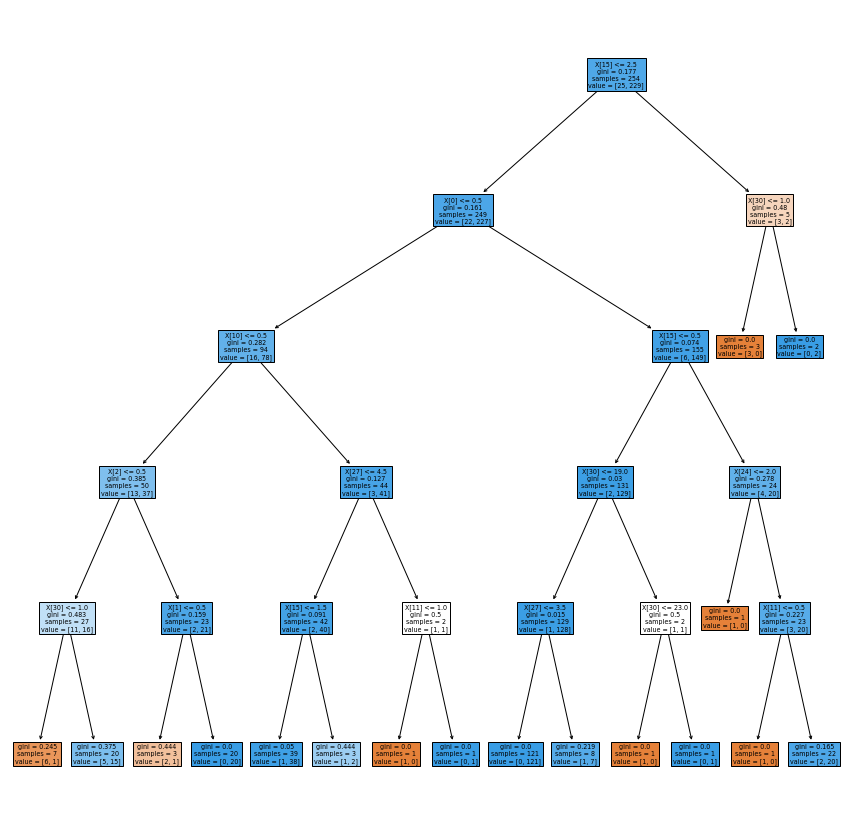

In [33]:
from sklearn import tree
fig= plt.figure(figsize=(15,15))
tree.plot_tree(svc_treeG3, filled=True)

Рисунок дерева здесь некрасивый и маленький, но изображение можно скачать, там можно все разглядеть!

## Задача многоклассовой классификации

так же, как и в задаче бинарной классификации, прежде всего необходим новый признак, основанный на G1

In [38]:
data1.loc[data1['G3'] < 8, 'G_4'] = int(0)
data1.loc[(data1['G3'] >= 8) & (data1['G3'] <= 13), 'G_4'] = int(1)
data1.loc[(data1['G3'] >= 14) & (data1['G3'] <= 17), 'G_4'] = int(2)
data1.loc[(data1['G3'] >= 18) & (data1['G3'] <= 20), 'G_4'] = int(3)

In [40]:
print(data1['G_4'])

2       1.0
3       2.0
8       0.0
11      2.0
13      1.0
14      0.0
16      1.0
17      1.0
18      1.0
19      1.0
21      2.0
22      2.0
24      1.0
26      1.0
28      2.0
29      1.0
30      1.0
32      2.0
39      1.0
40      2.0
47      1.0
48      1.0
50      1.0
56      1.0
59      2.0
64      2.0
69      2.0
73      1.0
76      2.0
79      1.0
       ... 
942     1.0
943     1.0
945     2.0
948     1.0
949     1.0
952     0.0
954     2.0
955     1.0
956     0.0
957     2.0
960     1.0
962     2.0
963     2.0
964     1.0
978     0.0
981     1.0
982     2.0
986     2.0
993     1.0
997     1.0
1003    1.0
1005    1.0
1006    1.0
1010    2.0
1016    1.0
1019    0.0
1024    2.0
1025    2.0
1040    1.0
1041    3.0
Name: G_4, Length: 339, dtype: float64


In [41]:
y_G4 = data1['G_4']
X_G4 = data1[features_name_G1]
train_XG4, val_XG4, train_yG4, val_yG4 = train_test_split(X_G4, y_G4, random_state = 43)

In [45]:
svc_treeG4 = DecisionTreeClassifier(max_leaf_nodes=5, random_state=43)
rfcG4 = AdaBoostClassifier(base_estimator=svc_treeG4, learning_rate=0.00001, random_state=43)
rfcG4.fit(train_XG4, train_yG4)
predict_ADAG4 = rfcG4.predict(val_XG4)

In [46]:
print(f1_score(val_yG4, predict_ADAG4, average='micro'))
svc_treeG4 = DecisionTreeClassifier(max_depth=5, random_state=43)
svc_treeG4.fit(train_XG4, train_yG4)
predict_svc_treeG4 = svc_treeG4.predict(val_XG4)
print(f1_score(val_yG4, predict_svc_treeG4, average='micro'))

0.6
0.5647058823529412


In [47]:
for i in [2,3,4,5,6,10,15,25]:
    svc_treeG4 = DecisionTreeClassifier(max_depth=i, random_state=43)
    svc_treeG4.fit(train_XG4, train_yG4)
    predict_svc_treeG4 = svc_treeG4.predict(val_XG4)
    print(f1_score(val_yG4, predict_svc_treeG4, average='micro'))

0.6352941176470588
0.5882352941176471
0.5176470588235295
0.5647058823529412
0.49411764705882355
0.4588235294117647
0.4823529411764706
0.4823529411764706


Как видно из первого цикла for в этой программе, чем меньше глубина дерева - тем точнее получается модель

Все дело в том, что параметров здесь не так много, поэтому при наращивании глубины дерева, после какого-то момента модель перестает находить какие-то закономерности, а просто "подгоняет" данные под ответ